# Boolean network model (based on Palma paper) with BeatAML data

In [2]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

# import booleanNetwork module from ./src
import sys
sys.path.append('./src/')
import booleanNetwork as bn
import BMatrix  

In [3]:
# ! pip install openpyxl

In [5]:
# data from 608 patients
# importing dataframe with patient id, mutation_profiles, and clinical_data
# call them patients_df if all the data should be used and patients_all if the data should be split
patients_df = pd.read_excel("./input_files/old_filtered_BeatAML/patient_mutation_blast_old.xlsx",keep_default_na=False)
print(patients_df)

# checking whether data is balanced
counts = patients_df['mutation_profiles'].value_counts()
print(counts)

        labId mutation_profiles   BM_Blast   PB_Blast
0    09-00705              NPM1  94.000000  97.000000
1    10-00136       FLT3,DNMT3A  80.000000  19.000000
2    10-00172              FLT3  91.000000  99.000000
3    10-00507         FLT3,NPM1  97.000000  97.000000
4    10-00542       FLT3,DNMT3A  87.000000  80.000000
..        ...               ...        ...        ...
603  16-01262                    90.000000  90.000000
604  16-01270                    55.694882  41.515937
605  17-00072                    55.694882  53.200000
606  17-00077                    90.000000  74.000000
607  17-00096                    55.694882  41.515937

[608 rows x 4 columns]
mutation_profiles
                    322
FLT3                 78
DNMT3A               50
FLT3,NPM1            40
FLT3,DNMT3A,NPM1     38
NPM1                 29
DNMT3A,NPM1          28
FLT3,DNMT3A          23
Name: count, dtype: int64


### Getting the variables needed for the simulation (like varF and F)

In [25]:
# get the equations for the boolean network, e.g. 'CCND1 = ! ( DNMT3A | GSK3B )'
file = './input_files/gene_equations.txt' 

# separate equations into left and right as preparation for Connectivity Matrix and Truth Table
equations = BMatrix.get_equations(file)
gene_dict = BMatrix.get_gene_dict(equations)
upstream_genes = BMatrix.get_upstream_genes(equations)

# Connectivity Matrix
connectivity_matrix = BMatrix.get_connectivity_matrix(equations,upstream_genes,gene_dict)
# print("Connectivity matrix:")
# print(connectivity_matrix)

# Truth Table 
truth_table = BMatrix.get_truth_table(equations,upstream_genes)
# print("Truth table:")
# print(truth_table)

ngenes = len(equations)

In [26]:
# Equations for calculating Apoptosis-, Differentiation- and Proliferation scores (in this order)
file_equations = './input_files/score_equations.txt'

cal_equations = BMatrix.get_equations(file_equations)
cal_upstream_genes = BMatrix.get_cal_upstream_genes(cal_equations)
cal_functions = BMatrix.get_cal_functions(cal_equations)

# print(cal_functions)

In [27]:
# File with 'constant' genes in their mutated form, e.g. oncogene 'FLT3 = 1'
# These genes will be set constant during the whole computation process. Either in their mutated or their wildtype form.

file_mutations = './input_files/mutations.txt'

mutation_dict = BMatrix.get_mutation_dict(file_mutations)
print(mutation_dict)

{'FLT3': 1, 'DNMT3A': 0, 'NPM1': 0}


### Running the simulation for all the 8 profiles from merged_df and getting the final scores

In [28]:
# get all unique mutation profiles
all_profiles = np.array([[profile] for profile in patients_df['mutation_profiles'].unique()])
print(all_profiles)

[['NPM1']
 ['FLT3,DNMT3A']
 ['FLT3']
 ['FLT3,NPM1']
 ['DNMT3A,NPM1']
 ['FLT3,DNMT3A,NPM1']
 ['DNMT3A']
 ['']]


In [29]:
final_separate_scores = {}
final_network_scores = {}
networks = {}
network_scores_steps = {}

steps = list(range(10000, 600001, 20000))

# Go through all mutation profiles 
for i in range(len(all_profiles)): 
    network_scores = []
    
    profile = all_profiles[i,0] # Get the profile as a string ex. 'FLT3, DNMT3A'
    print(profile)

    mutated_connectivity_matrix, x0 = BMatrix.get_knocking_genes(profile, mutation_dict, connectivity_matrix, gene_dict)
    # print(x0)


    #making the networks and running the simulation
    #print('starting simulation')
    network = bn.BooleanNetwork(ngenes, mutated_connectivity_matrix, truth_table, x0)
    network_traj = network.update_noise(0.05, 600000)

    for n in steps: 
        #calculating the scores  
        # print('getting final score')
        cal_range = network_traj[n//2:n]      # taking the second half of the simulation trajectory 

        # average value of all the nodes
        average_array = np.mean(cal_range, axis=0)
        # print(average_array)

        # calculating the scores for Apoptosis, Differentiation and Proliferation
        # as well as the final score = Proliferation - Differentiation - Apoptosis
        scores_dict, final_score, _ = BMatrix.get_calculating_scores(network_traj, cal_functions, cal_upstream_genes, gene_dict, cal_range)

        # print(final_score)
        # print('\n')

        network_scores.append(final_score)

    network_scores_steps.update({profile: network_scores})
    

# print(final_network_scores)

NPM1
FLT3,DNMT3A
FLT3
FLT3,NPM1
DNMT3A,NPM1
FLT3,DNMT3A,NPM1
DNMT3A

no_mutation


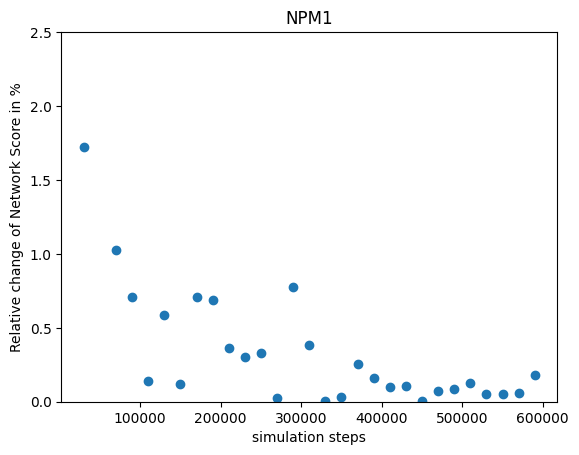

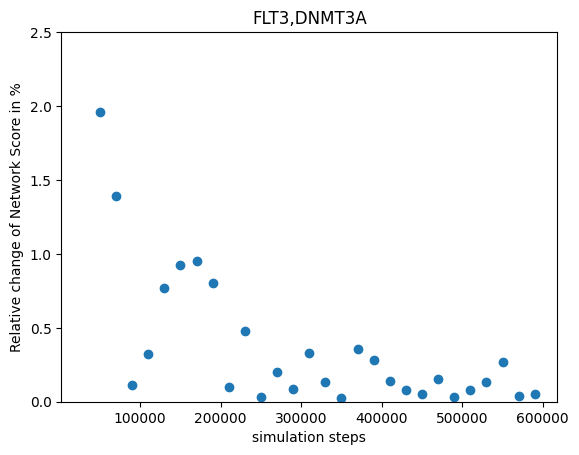

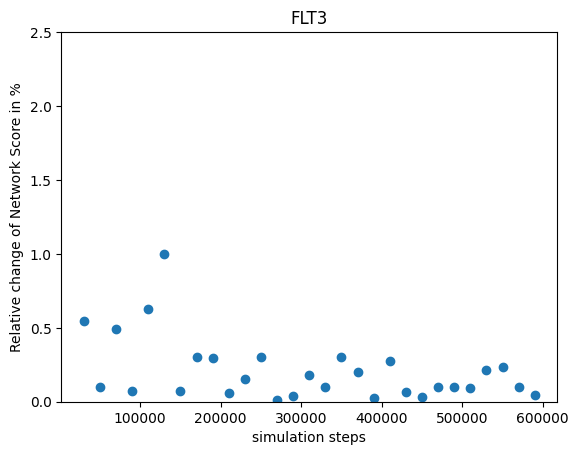

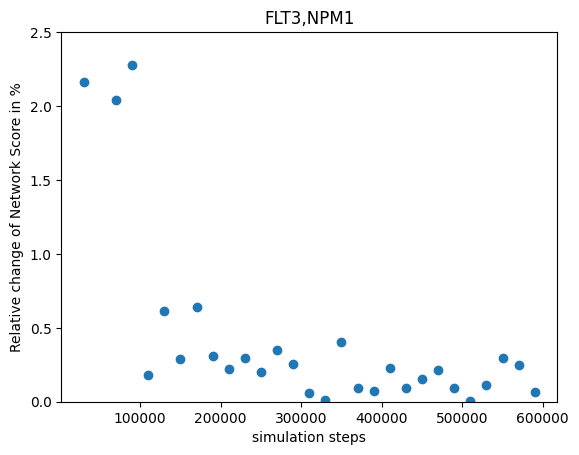

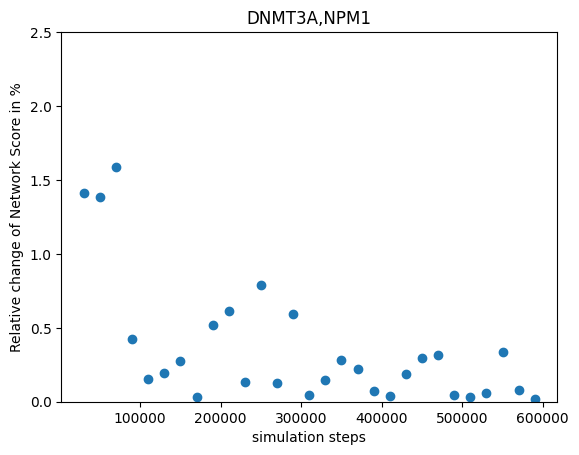

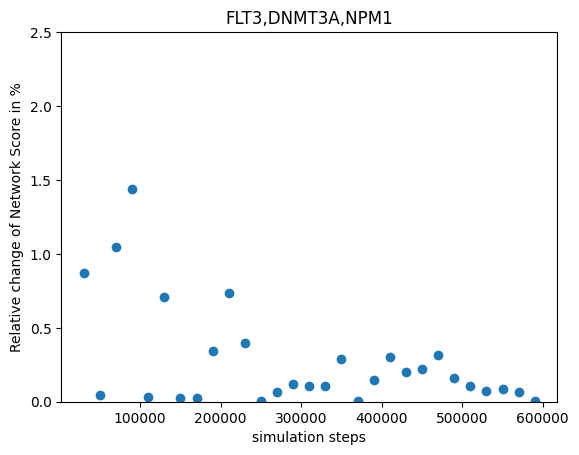

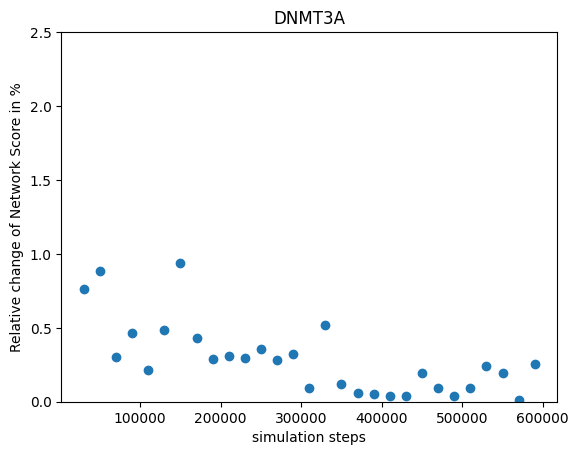

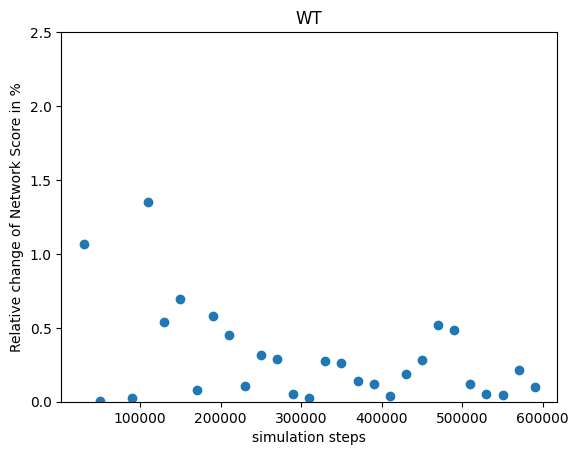

In [31]:

for i in range(len(all_profiles)):
    profile = all_profiles[i,0] # Get the profile as a string ex. 'FLT3, DNMT3A'
    # print(profile)
    
    network_scores = network_scores_steps[profile]
    
    # compute the difference in network scores
    rel_diff_network_scores = []
    for i in range(1, len(network_scores)):
        diff = network_scores[i] - network_scores[i - 1]
        rel_diff_network_scores.append(100*abs(diff))
    
    # print(network_scores)
    if profile=='':
        profile = 'WT'
    
    fig = plt.figure()
    plt.scatter(steps[1:], rel_diff_network_scores)
    plt.xlabel('simulation steps')
    plt.ylabel('Relative change of Network Score in %')
    plt.ylim(0, 2.5)
    plt.title(f'{profile}')
    plt.show()
    fig.savefig(f'Convergence of Network score for {profile}')

## Run for several (30) times to compute the error 

In [9]:
all_profiles = np.array([[profile] for profile in patients_df['mutation_profiles'].unique()])

final_separate_scores = {}
final_network_scores = {}
networks = {}
network_scores_several_times = {}      # this is a dictionary in which for each mutation profile 30 final network scores is given

n = 500000

In [ ]:
# Go through all mutation profiles 
for i in range(len(all_profiles)): 
    
    # reset variable network score 
    network_scores = []
    
    profile = all_profiles[i,0] # Get the profile as a string ex. 'FLT3, DNMT3A'
    print(profile)

    # run 30 times to compute error
    for j in range(30): 
        mutated_connectivity_matrix, x0 = BMatrix.get_knocking_genes(profile, mutation_dict, connectivity_matrix, gene_dict)
    
        # making the networks and running the simulation
        network = bn.BooleanNetwork(ngenes, mutated_connectivity_matrix, truth_table, x0)
        network_traj = network.update_noise(0.05, n)
        
        # take the second half of the trajectory 
        cal_range = network_traj[n//2:n]      

        # average value of all the nodes
        average_array = np.mean(cal_range, axis=0)

        # calculating the scores for Apoptosis, Differentiation and Proliferation
        # as well as the final score = Proliferation - Differentiation - Apoptosis
        scores_dict, final_score, _ = BMatrix.get_calculating_scores(network_traj, cal_functions, cal_upstream_genes, gene_dict, cal_range)
        
        network_scores.append(final_score)

    network_scores_several_times.update({profile: network_scores})

NPM1
FLT3,DNMT3A
FLT3
FLT3,NPM1
DNMT3A,NPM1
FLT3,DNMT3A,NPM1
DNMT3A


In [13]:
print(network_scores_several_times)

{'NPM1': [0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001, 0.5593480000000001], 'FLT3,DNMT3A': [6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316, 6.262316], 'FLT3': [3.8147399999999996, 3.8147399999999996, 3.8147399999999996, 3.8

In [19]:

# print the results

for i in range(len(all_profiles)): 
    profile = all_profiles[i,0]
    print(profile)
    print(f'mean: {np.mean(network_scores_several_times[profile])}')
    print(f'standard deviation : {np.std(network_scores_several_times[profile])}')

NPM1
mean: 0.5593480000000001
standard deviation : 0.0
FLT3,DNMT3A
mean: 6.262316
standard deviation : 0.0
FLT3
mean: 3.8147399999999996
standard deviation : 0.0
FLT3,NPM1
mean: 7.081707999999997
standard deviation : 1.7763568394002505e-15
DNMT3A,NPM1
mean: 0.548584
standard deviation : 0.0
FLT3,DNMT3A,NPM1
mean: 7.890671999999999
standard deviation : 1.7763568394002505e-15
DNMT3A
mean: -0.25923599999999986
standard deviation : 5.551115123125783e-17

mean: -1.8908160000000003
standard deviation : 2.220446049250313e-16
